In [1]:
def InitialSetup():
  #%%javascript
  %pip uninstall --y torch torchvision
  %pip install --pre torchvision -f  https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
  %pip install av

In [2]:
import torch
print(torch.__version__)
if torch.__version__ == '1.10.0+cu111':
  
  from google.colab import drive
  drive.mount('/content/drive')
  InitialSetup()

1.11.0+cu102


In [3]:
import numpy as np
import torch
import os
import sys
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
import tempfile

from glob import glob
from PIL import Image
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from urllib.request import urlretrieve
from torchvision.io import read_video
from torchvision.models.optical_flow import raft_large
from torchvision.models.optical_flow import raft_small
from torchvision.models.optical_flow import raft
from torchvision.utils import flow_to_image
from torchvision.transforms import ToTensor

In [4]:
im1 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP000L1S20120322T114453.tif")
im2 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP045L1S20120322T114453.tif")
im3 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP090L1S20120322T114453.tif")
im4 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP135L1S20120322T114453.tif")
im5 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP180L1S20120322T114453.tif")
im6 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP225L1S20120322T114453.tif")
im7 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP270L1S20120322T114453.tif")
im8 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP315L1S20120322T114453.tif")
im1.show()

Text(0.5, 1.0, 'Eighth')

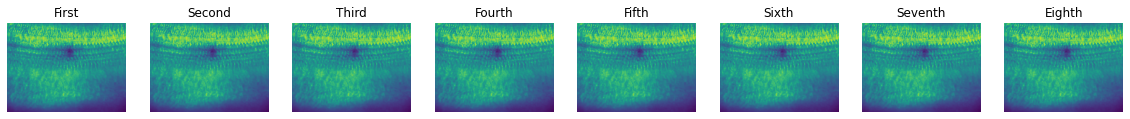

In [30]:
rows = 1
columns = 8

fig = plt.figure(figsize=(20, 10))

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(im1)
plt.axis('off')
plt.title("First")

fig.add_subplot(rows, columns, 2)
plt.imshow(im2)
plt.axis('off')
plt.title("Second")
  
fig.add_subplot(rows, columns, 3)
plt.imshow(im3)
plt.axis('off')
plt.title("Third")
  
fig.add_subplot(rows, columns, 4)
plt.imshow(im4)
plt.axis('off')
plt.title("Fourth")

fig.add_subplot(rows, columns, 5)
plt.imshow(im5)
plt.axis('off')
plt.title("Fifth")

fig.add_subplot(rows, columns, 6)
plt.imshow(im6)
plt.axis('off')
plt.title("Sixth")

fig.add_subplot(rows, columns, 7)
plt.imshow(im7)
plt.axis('off')
plt.title("Seventh")

fig.add_subplot(rows, columns, 8)
plt.imshow(im8)
plt.axis('off')
plt.title("Eighth")

In [5]:
imarray1 = np.array(im1)
imarray2 = np.array(im2)
print(imarray1.shape)
print(imarray2.shape)
print(im1.size)
print(im2.size)

(1200, 1600)
(1200, 1600)
(1600, 1200)
(1600, 1200)


In [6]:
img1_batch=ToTensor()(im1)
img2_batch=ToTensor()(im2)
img3_batch = torch.stack([img1_batch, img2_batch])
img4_batch = torch.stack([img1_batch, img2_batch])
def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            T.Resize(size=(128, 128)),
        ]
    )
    batch = transforms(batch)
    return batch


# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

img1_batch_t = preprocess(img3_batch).to(device)
img2_batch_t = preprocess(img4_batch).to(device)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([1, 1200, 1600]), dtype = torch.int16


In [7]:
print(f"shape = {img1_batch_t.shape}, dtype = {img1_batch_t.dtype}")
print(f"shape = {img2_batch_t.shape}, dtype = {img2_batch_t.dtype}")

shape = torch.Size([2, 1, 128, 128]), dtype = torch.float32
shape = torch.Size([2, 1, 128, 128]), dtype = torch.float32


In [8]:
img1_batch_t = img1_batch_t.repeat(1,3,1,1)
img2_batch_t = img2_batch_t.repeat(1,3,1,1)
#print(f"shape = {img1_batch_t.shape}, dtype = {img1_batch_t.dtype}")
#img1_batch_t=img1_batch_t[None,:, :,:]
#img2_batch_t=img2_batch_t[None,:, :,:]

In [9]:
print(f"shape = {img1_batch_t.shape}, dtype = {img1_batch_t.dtype}")
print(f"shape = {img2_batch_t.shape}, dtype = {img2_batch_t.dtype}")

shape = torch.Size([2, 3, 128, 128]), dtype = torch.float32
shape = torch.Size([2, 3, 128, 128]), dtype = torch.float32


In [10]:
def model_summary(model):
  print("model_summary")
  print()
  print("Layer_name"+"\t"*7+"Number of Parameters")
  print("="*100)
  model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
  layer_name = [child for child in model.children()]
  j = 0
  total_params = 0
  print("\t"*10)
  for i in layer_name:
    print()
    param = 0
    try:
      bias = (i.bias is not None)
    except:
      bias = False  
    if not bias:
      param =model_parameters[j].numel()+model_parameters[j+1].numel()
      j = j+2
    else:
      param =model_parameters[j].numel()
      j = j+1
    print(str(i)+"\t"*3+str(param))
    total_params+=param
  print("="*100)
  print(f"Total Params:{total_params}")       



In [11]:
print(f"shape = {img2_batch.shape}, dtype = {img2_batch.dtype}")
model = raft_small(pretrained=True, progress=False).to(device)
#model_summary(model)
#model_vals=[layer for layer in model.parameters()]
#print(model_vals)
#print(model.parameters)
model = model.eval()

list_of_flows = model(img1_batch_t.to(device), img2_batch_t.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

shape = torch.Size([1, 1200, 1600]), dtype = torch.int16


Downloading: "https://download.pytorch.org/models/raft_small_C_T_V2-01064c6d.pth" to /root/.cache/torch/hub/checkpoints/raft_small_C_T_V2-01064c6d.pth


type = <class 'list'>
length = 12 = number of iterations of the model


In [12]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 128, 128]) = (N, 2, H, W)
min = -0.5388110280036926, max = 0.4056892395019531


In [13]:
def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

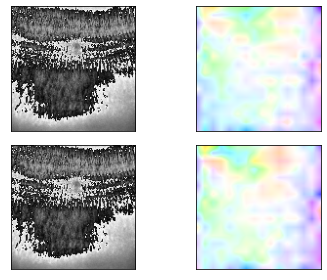

In [14]:
flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch_t]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)